# Federated Learning - Minimal Example

## Setup
---

### Imports
---

In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import product
from math import floor
import time

import tensorflow as tf
import tensorflow_federated as tff
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import CSVLogger

# -> check tff
#print(tff.federated_computation(lambda: 'Hello World')()) 

2023-05-11 07:20:49.610723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 07:20:51.205183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Ingest Data
---

In [2]:
# ingest data

df_locs = ['../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

def load_df(df_locs):
    """ Loads data from a path to a csv-file.
    
    :param df_locs: possible locations of a CSV file
    :type df_locs: str or list of str
    :output: Ingested Data.
    :rtype: pandas.DataFrame 
    """
    df = pd.DataFrame()

    if isinstance(df_locs, str): df_locs = [df_locs]
    
    for df_loc in df_locs:
        try:
            df = pd.read_csv(df_loc, index_col = 0)
            print("loaded data from {}".format(df_loc))
            if len(df) != 0: break
        except Exception as ex:
            print("{} in ".format(type(ex).__name__), df_loc)

    return df

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [3]:
# select features and target (first column)
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']
target = 'charges'

df.loc[:, [target]+features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


## Stepwise
---

### Create Data Shards (Federated)
---

In [5]:
# Prepare the data
# =====================

# 1. create client data
# =====================

#client_seperator = 'region'
#clients = [
#    df.loc[df[client_seperator] == x, df.columns != client_seperator][[target] + features] 
#    for x in df[client_seperator].unique()
#    ]
# or randomly
clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]


# 2. evaluation splits
# ====================

clients_split = [train_test_split(data, test_size = 20, random_state = 42) for data in clients]
clients_train = [split[0] for split in clients_split]
test_data_fed  = [split[1] for split in clients_split]

# for cross validation use:
#cv = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state = 42)
#client_cv_splits = [cv.split(data) for data in clients]
#[[[data.iloc[train,:], data.iloc[test,:]] for train, test in cv.split(data)] for data in clients][1][1]

# prep the data (incl. convert to tensor)
# =======================================

def prep_fed_train(X_train, y_train,
    #NUM_EPOCHS = 50,
    #BATCH_SIZE = 128,
    #SHUFFLE_BUFFER = 20,
    #PREFETCH_BUFFER = 5,
    #SEED = 42
    ):
    """
    See https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#preprocessing_the_input_data
    """

    return tf.data.Dataset.from_tensor_slices((
        tf.convert_to_tensor(X_train), 
        tf.convert_to_tensor(y_train)
        ))

#def prep_fed_test(X_test, y_test):
#    return tf.data.Dataset.from_tensor_slices((
#        tf.convert_to_tensor(np.expand_dims(X_test, axis=0)), 
#        tf.convert_to_tensor(np.expand_dims(y_test, axis=0))
#        )) 

train_data_fed = [prep_fed_train(df[features], df[target]) for df in clients_train]
#test_data_fed  = [prep_fed_test (df[features], df[target]) for df in clients_test]

# show random_client_ds
if False: # only correct, without #.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)
    i = 0 
    for client_dfs in random_client_ds:
        print('================================ client {} =================================='.format(i))
        client_train = list(client_dfs[0].as_numpy_iterator())
        client_test  = list(client_dfs[1])
        print('Train (obs = {})'.format(len(client_train[0])))

        print(pd.DataFrame(client_train[:3], columns = ["X", "y"]))
        print('Test (obs = {})'.format(len(client_test[0])))
        #print('obs: {}')
        print(pd.DataFrame(client_test[:3], columns = ["X", "y"]))
        # print([x[:3] for x in client_test])
        i += 1

2023-05-11 07:21:57.068572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-11 07:21:57.215127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-11 07:21:57.215192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-11 07:21:57.218940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-11 07:21:57.219010: I tensorflow/compile

### Build Federated Model
---

In [8]:
# build a TFF model from Keras
# ============================

def create_keras_model(
    nfeatures = 9,
    units = [40, 40, 20], 
    activations = ['relu'] * 3, 
    compile = True,
    loss = tf.losses.mae,
    optimizer = tf.optimizers.legacy.Adam(learning_rate = .05),
    metrics = ["mae", 'mean_squared_error', r2_score], 
    run_eagerly = True
    ):
  
  """Construct a fully connected neural network and compile it.
  
  Parameters
  ------------
  nfeatures: int, optional
    Number of input features. Default is 9.
  units: list of int, optional
    List of number of units of the hidden dense layers. The length of ``units`` defines the number of hidden layers. Default are 3 layers with 40, 40 an 20 units, respectively.
  activations: list of str, optional
    List of activation functions used in the hidden layers.
  loss: str, optional
    Used loss function for compiling.
  optimizer: keras.optimizers, optional
    Used optimizer for compiling.
  metrics: list of str or sklearn.metrics
    List of metrics for compiling.
  run_eagerly: bool
    Parameter for compiling

  Return
  ------------
    model: keras.engine.sequential.Sequential
      Keras sequential fully connected neural network. Already compiled.
  """
  
  # construct model
  model = Sequential()
  model.add(InputLayer(input_shape = [nfeatures]))
  for ind in range(len(units)):
    model.add(Dense(
      units = units[ind], 
      activation = activations[ind]
      ))
  model.add(Dense(1))
  
  # compile model
  if compile:
    model.compile(
      loss = loss,
      optimizer = optimizer,
      metrics = metrics,
      run_eagerly = run_eagerly
    )

  return model


def model_fn(
    keras_creator,
    loss = tf.keras.losses.MeanAbsoluteError()
    #,metrics = [tf.keras.metrics.MeanAbsoluteError()]
    ):
    """ Wrap a Keras model as Tensorflow Federated model. 
    
    cf. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras
    """
    def _model():
        # We _must_ create a new model here, and _not_ capture it from an external
        # scope. TFF will call this within different graph contexts.
        
        #keras_model = create_keras_model(
        #    nfeatures = nfeatures, compile = False#, **kwargs
        #    )
        
        keras_model = keras_creator()

        return tff.learning.models.from_keras_model(
            keras_model,
            input_spec = (
                tf.TensorSpec((None, keras_model.input.shape[1]
                ), dtype = tf.float64),
                tf.TensorSpec((None,),           dtype = tf.float64)
            ), loss = loss, metrics =  [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()]
        )

    return _model

### Train
---

In [331]:
def keras_blueprint():
    return create_keras_model(nfeatures = 9, compile = False, units =[40,40,20])

#print(keras_blueprint().summary())
#model_fed = model_fn(keras_creator = keras_blueprint)

client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05)
server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05)

# Create iterative learning process which will perform the federated learning
process_fed = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn(keras_creator = keras_blueprint),
    client_optimizer_fn = client_optimizer,
    server_optimizer_fn = server_optimizer)

# show the learning process
#print(process_fed.initialize.type_signature.formatted_representation())

In [12]:
def train_fed(process, train_data,
    NUM_ROUNDS = 50,
    NUM_EPOCHS = 50,
    BATCH_SIZE = 128,
    SHUFFLE_BUFFER = 20,
    PREFETCH_BUFFER = 5,
    SEED = 42,
    verbose = True
    ):
    
    # prep the data
    train_data = [
        data.
            repeat(NUM_EPOCHS).
            shuffle(SHUFFLE_BUFFER, seed = SEED).
            batch(BATCH_SIZE).
            prefetch(PREFETCH_BUFFER)

        for data in train_data]
    
    # initialize the process
    state = process.initialize()
    hist= []

    for round in range(NUM_ROUNDS):
        
        if SEED != None: tf.keras.utils.set_random_seed(SEED)
        result  = process.next(state, train_data)
        
        state   = result.state
        metrics = dict(result.metrics['client_work']['train'].items())

        hist.append(metrics)

        if verbose == True: print('round {:2d} / {}, metrics = {}'.format(round + 1, NUM_ROUNDS, metrics))


    return {'process': process, 'history': hist, 'state': state}




In [334]:
result = train_fed(
    process = process_fed, 
    train_data = train_data_fed, 
    NUM_ROUNDS = 50, 
    NUM_EPOCHS = 50
    )

round  1 / 50, metrics = {'loss': 5520.089, 'num_examples': 62800, 'num_batches': 492}
round  2 / 50, metrics = {'loss': 5230.4956, 'num_examples': 62800, 'num_batches': 492}
round  3 / 50, metrics = {'loss': 5094.0776, 'num_examples': 62800, 'num_batches': 492}
round  4 / 50, metrics = {'loss': 4967.2173, 'num_examples': 62800, 'num_batches': 492}
round  5 / 50, metrics = {'loss': 4846.826, 'num_examples': 62800, 'num_batches': 492}
round  6 / 50, metrics = {'loss': 4733.1904, 'num_examples': 62800, 'num_batches': 492}
round  7 / 50, metrics = {'loss': 4636.036, 'num_examples': 62800, 'num_batches': 492}
round  8 / 50, metrics = {'loss': 4513.5933, 'num_examples': 62800, 'num_batches': 492}
round  9 / 50, metrics = {'loss': 4413.205, 'num_examples': 62800, 'num_batches': 492}
round 10 / 50, metrics = {'loss': 4304.1987, 'num_examples': 62800, 'num_batches': 492}
round 11 / 50, metrics = {'loss': 4231.1055, 'num_examples': 62800, 'num_batches': 492}
round 12 / 50, metrics = {'loss': 41

### Test
---

In [346]:
model_weights = iterative_process.get_model_weights(result['state'])

In [308]:
# Model evaluation
evaluation = tff.learning.build_federated_evaluation(model_fed)
# print(evaluation.type_signature.formatted_representation())
perf = evaluation(model_weights, test_data_fed)

/tmp/ipykernel_83655/433970590.py:2: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  evaluation = tff.learning.build_federated_evaluation(model_fed)
2023-05-10 17:27:12.413307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 17:27:12.413367: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-10 17:27:12.413490: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-10 17:27:12.413854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 17:27:12.413924: I tensorflow

In [309]:
perf

OrderedDict([('eval',
              OrderedDict([('loss', 2007.8079),
                           ('num_examples', 80),
                           ('num_batches', 4)]))])

In [345]:
model = keras_blueprint()
model_weights.assign_weights_to(model)
model.compile(
    loss=tf.losses.mae,
    # loss=tf.losses.mean_squared_error,
    optimizer=tf.optimizers.Adam(),
    metrics=["mae", 'mean_squared_error']
)

X_test = pd.concat([data[features] for data in clients_test])
y_test = pd.concat([data[target]   for data in clients_test])

# The evaluation results, for technical reasons the metrics_names is called afterwards. However, its order fits to the results
print(model.evaluate(X_test, y_test, verbose = 0))
print(model.metrics_names)


[1718.9088134765625, 1718.9088134765625, 24081804.0]
['loss', 'mae', 'mean_squared_error']


## Summary
---

In [403]:
# 1. create client data
# =====================
#client_seperator = 'region'
#clients = [
#    df.loc[df[client_seperator] == x, df.columns != client_seperator][[target] + features] 
#    for x in df[client_seperator].unique()
#    ]
# or randomly
clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]

# 2. evaluation splits
# ====================
clients_split = [train_test_split(data, test_size = 20, random_state = 42) for data in clients]
clients_train = [split[0] for split in clients_split]
clients_test  = [split[1] for split in clients_split]


# 3. convert to tensor
# ====================
train_data_fed = [prep_fed_train(df[features], df[target]) for df in clients_train]
test_data_fed  = [prep_fed_test (df[features], df[target]) for df in clients_test]


# 4. Specify model and optimizer
# ==============================
def keras_blueprint(compile = False):
    return create_keras_model(
        nfeatures = 9, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

#print(keras_blueprint().summary())
# rem.: has to be a generator so that build_weighted_fed_avg works

client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05)
server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05)

# 5. Create iterative FL process
# ===============================
# Create iterative learning process which will perform the federated learning
process_fed = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn(keras_creator = keras_blueprint),
    client_optimizer_fn = client_optimizer,
    server_optimizer_fn = server_optimizer)

# 6. trigger training
# ===================
train_result = train_fed(
    process_fed, 
    train_data_fed,
    NUM_ROUNDS = 100,
    NUM_EPOCHS = 70,
    BATCH_SIZE = 128,
    SHUFFLE_BUFFER = 20,
    PREFETCH_BUFFER = 5,
    SEED = 42,
    verbose = True
    )


print("Performance Train: {}".format(train_result["history"][-1]))

# 7. Test
# =======
model_weights = train_result['process'].get_model_weights(result['state'])
model = create_keras_model(compile = True)
model_weights.assign_weights_to(model)

X_test = pd.concat([data[features] for data in clients_test])
y_test = pd.concat([data[target]   for data in clients_test])


test_performance = model.evaluate(X_test, y_test, verbose = 0)
test_performance = dict(zip(model.metrics_names, [round(x , 3) for x in test_performance]))
print("Performance Test: {}".format(test_performance))


2023-05-10 22:41:26.872727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 22:41:26.872793: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-10 22:41:26.872934: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-10 22:41:26.873457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 22:41:26.873548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 22:41:26.873605: I tensor

round  1 / 100, metrics = {'mean_absolute_error': 4497.5444, 'mean_squared_error': 74540490.0, 'loss': 4500.707, 'num_examples': 87920, 'num_batches': 688}
round  2 / 100, metrics = {'mean_absolute_error': 4356.469, 'mean_squared_error': 70370050.0, 'loss': 4359.381, 'num_examples': 87920, 'num_batches': 688}
round  3 / 100, metrics = {'mean_absolute_error': 4217.549, 'mean_squared_error': 67186940.0, 'loss': 4220.341, 'num_examples': 87920, 'num_batches': 688}
round  4 / 100, metrics = {'mean_absolute_error': 4104.527, 'mean_squared_error': 64368844.0, 'loss': 4107.152, 'num_examples': 87920, 'num_batches': 688}
round  5 / 100, metrics = {'mean_absolute_error': 4007.3503, 'mean_squared_error': 61854110.0, 'loss': 4009.7048, 'num_examples': 87920, 'num_batches': 688}
round  6 / 100, metrics = {'mean_absolute_error': 3877.418, 'mean_squared_error': 58660170.0, 'loss': 3879.9304, 'num_examples': 87920, 'num_batches': 688}
round  7 / 100, metrics = {'mean_absolute_error': 3764.229, 'mean_

## Automation
---

### Setup
---

#### Process

In [9]:
# Specify model and optimizer
# ==============================
def keras_blueprint(compile = False):
    return create_keras_model(
        nfeatures = 9, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

#print(keras_blueprint().summary())
# rem.: has to be a generator so that build_weighted_fed_avg works

client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05)
server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05)

# 5. Create iterative FL process
# ===============================
# Create iterative learning process which will perform the federated learning
process_fed = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn(keras_creator = keras_blueprint),
    client_optimizer_fn = client_optimizer,
    server_optimizer_fn = server_optimizer)

print(process_fed.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[9,40],
      float32[40],
      float32[40,40],
      float32[40],
      float32[40,20],
      float32[20],
      float32[20,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[9,40],
    float32[9,40],
    float32[40],
    float32[40],
    float32[40,40],
    float32[40,40],
    float32[40],
    float32[40],
    float32[40,20],
    float32[40,20],
    float32[20],
    float32[20],
    float32[20,1],
    float32[20,1],
    float32[1],
    float32[1]
  >
>@SERVER)


#### Evaluation

In [10]:
# Specify evaluation

#client_seperator = 'region'
#clients = [
#    df.loc[df[client_seperator] == x, df.columns != client_seperator][[target] + features] 
#    for x in df[client_seperator].unique()
#    ]
# or randomly
clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]

# 2. evaluation splits
# ====================
#client_split = [train_test_split(data, test_size = 20, random_state = 42) for data in clients]
#client_train = [split[0] for split in clients_split]
#client_test  = [split[1] for split in clients_split]

nfolds = 5
nreps  = 5

cv = RepeatedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
client_splits = [list(cv.split(data)) for data in clients]
#[[[data.iloc[train,:], data.iloc[test,:]] for train, test in cv.split(data)] for data in clients][1][1]

### Train

In [13]:
results = []

for i in range(nfolds * nreps):
    indices_train = [split[i][0] for split in client_splits]
    clients_train = [clients[i].iloc[indices_train[i]] for i in range(len(clients))]

    train_data_fed = [prep_fed_train(df[features], df[target]) for df in clients_train]

    result = train_fed(
        process_fed, 
        train_data_fed,
        NUM_ROUNDS = 50,
        NUM_EPOCHS = 50,
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )

    results.append(result)
    print("trial {} / {}: performance train = {}".format(i + 1, nfolds * nreps,result["history"][-1]))

2023-05-11 07:25:25.459750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-11 07:25:25.459812: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-11 07:25:25.459945: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-11 07:25:25.460274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-11 07:25:25.460330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-11 07:25:25.460372: I tensor

trial 1 / 25: performance train = {'mean_absolute_error': 2084.477, 'mean_squared_error': 25657180.0, 'loss': 2084.7004, 'num_examples': 53400, 'num_batches': 420}
trial 2 / 25: performance train = {'mean_absolute_error': 2134.2646, 'mean_squared_error': 25497122.0, 'loss': 2131.0093, 'num_examples': 53400, 'num_batches': 420}
trial 3 / 25: performance train = {'mean_absolute_error': 1992.6439, 'mean_squared_error': 23477794.0, 'loss': 1993.5251, 'num_examples': 53400, 'num_batches': 420}
trial 4 / 25: performance train = {'mean_absolute_error': 2078.1604, 'mean_squared_error': 25751186.0, 'loss': 2078.2725, 'num_examples': 53400, 'num_batches': 420}
trial 5 / 25: performance train = {'mean_absolute_error': 1963.4685, 'mean_squared_error': 23214434.0, 'loss': 1963.2606, 'num_examples': 53600, 'num_batches': 420}
trial 6 / 25: performance train = {'mean_absolute_error': 2014.9293, 'mean_squared_error': 24360726.0, 'loss': 2018.8647, 'num_examples': 53400, 'num_batches': 420}
trial 7 / 2

#### Train Performance

tba: plot

In [14]:
# show train performance
pd.DataFrame([res['history'][-1] for res in results]).assign(
    RMSE = lambda x: np.sqrt(x.mean_squared_error),
    MAE = lambda x: x.mean_absolute_error
)[['MAE', 'RMSE']].describe().round(2)

,MAE,RMSE
count,25.00,25.00
mean,2064.25,4980.81
std,65.83,125.65
min,1963.47,4805.34
25%,2014.93,4864.61
50%,2064.99,4964.64
75%,2102.97,5065.29
max,2239.33,5290.17


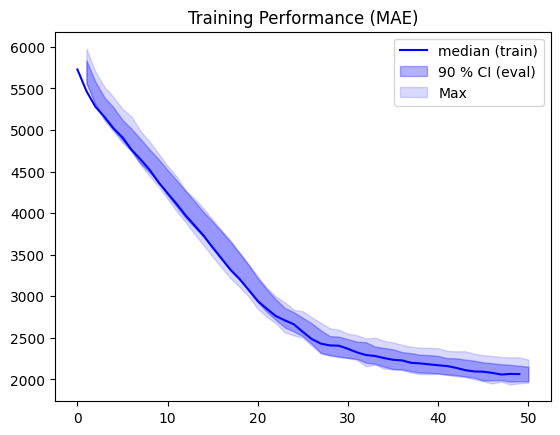

In [46]:
y = np.array([[hist['mean_absolute_error'] for  hist in res['history']]
              for res in results]).transpose()

plt.title('Training Performance (MAE)')

#plt.plot(y)
plt.plot(np.quantile(y,.5, axis = 1), label = 'median (train)', color = 'blue')
plt.fill_between(range(1, 50 +1), np.quantile(y,.05, axis = 1), np.quantile(y,.95, axis = 1),color = 'blue', alpha = 0.3, label = '90 % CI (eval)')
plt.fill_between(range(1, 50 +1), np.min(y,axis = 1), np.max(y,axis = 1),color = 'blue', alpha = 0.15, label = 'Max')

#plt.fill_between(range(1, 50 +1), np.quantile(y,.4, axis = 1), np.quantile(y,.6, axis = 1),color = 'blue', alpha = 0.15, label = '90 % CI (eval)')
plt.legend()
plt.show()

### Test

In [16]:
# calculae test performance
test_perfs = []
for i in range(nfolds * nreps):
    
    indices_test  = [split[i][1] for split in client_splits]
    clients_test  = [clients[i].iloc[indices_test [i]] for i in range(len(clients))]

    model_weights = results[i]['process'].get_model_weights(results[i]['state'])
    model = create_keras_model(compile = True)
    model_weights.assign_weights_to(model)

    X_test = pd.concat([data[features] for data in clients_test])
    y_test = pd.concat([data[target]   for data in clients_test])


    perf = model.evaluate(X_test, y_test, verbose = 0)
    perf = dict(zip(model.metrics_names, [round(x , 3) for x in perf]))
    test_perfs.append(perf)
    print("trial {} / {}: performance test = {}".format(i + 1, nfolds * nreps, perf))


2023-05-11 07:30:19.875086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


trial 1 / 25: performance test = {'loss': 1986.589, 'mae': 1986.589, 'mean_squared_error': 22962486.0, 'r2_score': 0.835}
trial 2 / 25: performance test = {'loss': 1870.257, 'mae': 1870.257, 'mean_squared_error': 23130758.0, 'r2_score': 0.808}
trial 3 / 25: performance test = {'loss': 2967.271, 'mae': 2967.271, 'mean_squared_error': 41563176.0, 'r2_score': 0.702}
trial 4 / 25: performance test = {'loss': 2137.745, 'mae': 2137.745, 'mean_squared_error': 25340180.0, 'r2_score': 0.831}
trial 5 / 25: performance test = {'loss': 2931.379, 'mae': 2931.379, 'mean_squared_error': 40385732.0, 'r2_score': 0.685}
trial 6 / 25: performance test = {'loss': 2305.632, 'mae': 2305.632, 'mean_squared_error': 28983710.0, 'r2_score': 0.728}
trial 7 / 25: performance test = {'loss': 2544.025, 'mae': 2544.025, 'mean_squared_error': 30571870.0, 'r2_score': 0.775}
trial 8 / 25: performance test = {'loss': 2660.483, 'mae': 2660.483, 'mean_squared_error': 35515644.0, 'r2_score': 0.783}
trial 9 / 25: performanc

In [48]:
# describe test performance
pd.DataFrame(test_perfs).assign(
    RMSE = lambda x: np.sqrt(x.mean_squared_error),
    MAE = lambda x: x.mae,
    RSQ_pct = lambda x: x.r2_score * 100
)[['MAE', 'RMSE', 'RSQ_pct']].describe()[1:].round(2)

,MAE,RMSE,RSQ_pct
mean,2405.75,5482.21,76.9
std,417.68,687.35,5.6
min,1549.06,4008.72,66.3
25%,2137.74,5033.90,72.8
50%,2389.53,5529.18,77.5
75%,2701.43,6000.15,80.4
max,3111.87,6446.95,90.2


In [49]:
pd.DataFrame(test_perfs).assign(
    RMSE = lambda x: np.sqrt(x.mean_squared_error),
    MAE = lambda x: x.mae,
    RSQ_pct = lambda x: x.r2_score * 100
)[['MAE', 'RMSE', 'RSQ_pct']].describe()[1:].round(2).to_csv("../output/fl_test_performance_overview.csv", sep = ";")

In [50]:
# show test performance completely
pd.DataFrame(test_perfs).assign(
    RMSE = lambda x: np.sqrt(x.mean_squared_error),
    MAE = lambda x: x.mae,
    RSQ_pct = lambda x: x.r2_score * 100
)[['MAE', 'RMSE', 'RSQ_pct']].round(2)

,MAE,RMSE,RSQ_pct
0,1986.59,4791.92,83.5
1,1870.26,4809.44,80.8
2,2967.27,6446.95,70.2
3,2137.74,5033.90,83.1
4,2931.38,6354.98,68.5
5,2305.63,5383.65,72.8
6,2544.02,5529.18,77.5
7,2660.48,5959.50,78.3
8,2281.61,5327.44,79.4
9,2338.14,5509.40,78.7


In [537]:
print("Relative error {:.2f} %".format((80.95 - 65.8) / 80.95 * 100))

Relative error 18.72 %


### Real Clients


In [59]:
# Specify evaluation

client_seperator = 'region'
clients = [
   df.loc[df[client_seperator] == x, df.columns != client_seperator][[target] + features[:5]] 
   for x in df[client_seperator].unique()
   ]
# or randomly
#clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]


nfolds = 5
nreps  = 5

cv = RepeatedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
client_splits = [list(cv.split(data)) for data in clients]


In [58]:
# Specify model and optimizer
# ==============================
def keras_blueprint(compile = False):
    return create_keras_model(
        nfeatures = 5, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

#print(keras_blueprint().summary())
# rem.: has to be a generator so that build_weighted_fed_avg works

client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05)
server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05)

# 5. Create iterative FL process
# ===============================
# Create iterative learning process which will perform the federated learning
process_fed = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn(keras_creator = keras_blueprint),
    client_optimizer_fn = client_optimizer,
    server_optimizer_fn = server_optimizer)

print(process_fed.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[5,40],
      float32[40],
      float32[40,40],
      float32[40],
      float32[40,20],
      float32[20],
      float32[20,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[5,40],
    float32[5,40],
    float32[40],
    float32[40],
    float32[40,40],
    float32[40,40],
    float32[40],
    float32[40],
    float32[40,20],
    float32[40,20],
    float32[20],
    float32[20],
    float32[20,1],
    float32[20,1],
    float32[1],
    float32[1]
  >
>@SERVER)


In [60]:
results_cl = []

for i in range(nfolds * nreps):
    indices_train = [split[i][0] for split in client_splits]
    clients_train = [clients[i].iloc[indices_train[i]] for i in range(len(clients))]

    train_data_fed = [prep_fed_train(df[features[:5]], df[target]) for df in clients_train]

    result = train_fed(
        process_fed, 
        train_data_fed,
        NUM_ROUNDS = 50,
        NUM_EPOCHS = 50,
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )

    results_cl.append(result)
    print("trial {} / {}: performance train = {}".format(i + 1, nfolds * nreps,result["history"][-1]))

2023-05-11 07:50:37.993426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-11 07:50:37.993476: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-11 07:50:37.994284: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-11 07:50:37.994941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-11 07:50:37.995047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-11 07:50:37.995090: I tensor

trial 1 / 25: performance train = {'mean_absolute_error': 2045.2416, 'mean_squared_error': 24609214.0, 'loss': 2045.5366, 'num_examples': 53500, 'num_batches': 420}
trial 2 / 25: performance train = {'mean_absolute_error': 1930.1128, 'mean_squared_error': 22297678.0, 'loss': 1927.9725, 'num_examples': 53500, 'num_batches': 420}
trial 3 / 25: performance train = {'mean_absolute_error': 2084.4988, 'mean_squared_error': 25817156.0, 'loss': 2083.422, 'num_examples': 53500, 'num_batches': 420}
trial 4 / 25: performance train = {'mean_absolute_error': 1964.7667, 'mean_squared_error': 23173124.0, 'loss': 1964.6301, 'num_examples': 53500, 'num_batches': 420}
trial 5 / 25: performance train = {'mean_absolute_error': 2145.7595, 'mean_squared_error': 26316158.0, 'loss': 2142.9639, 'num_examples': 53600, 'num_batches': 421}
trial 6 / 25: performance train = {'mean_absolute_error': 2000.0353, 'mean_squared_error': 23814930.0, 'loss': 1999.0714, 'num_examples': 53500, 'num_batches': 420}
trial 7 / 2

In [63]:
# show train performance
pd.DataFrame([res['history'][-1] for res in results_cl]).assign(
    RMSE = lambda x: np.sqrt(x.mean_squared_error),
    MAE = lambda x: x.mean_absolute_error
)[['MAE', 'RMSE']].describe().round(2)[1:]

,MAE,RMSE
mean,2034.70,4940.01
std,65.18,121.30
min,1930.11,4722.04
25%,1983.79,4863.62
50%,2029.12,4905.07
75%,2061.68,5000.32
max,2190.81,5188.62


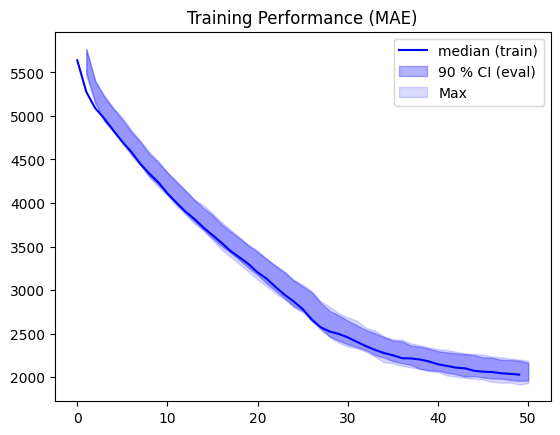

In [69]:
y = np.array([[hist['mean_absolute_error'] for  hist in res['history']]
              for res in results_cl]).transpose()

plt.title('Training Performance (MAE)')

#plt.plot(y)
plt.plot(np.quantile(y,.5, axis = 1), label = 'median (train)', color = 'blue')
plt.fill_between(range(1, 50 +1), np.quantile(y,.05, axis = 1), np.quantile(y,.95, axis = 1),color = 'blue', alpha = 0.3, label = '90 % CI (eval)')
plt.fill_between(range(1, 50 +1), np.min(y,axis = 1), np.max(y,axis = 1),color = 'blue', alpha = 0.15, label = 'Max')

#plt.fill_between(range(1, 50 +1), np.quantile(y,.4, axis = 1), np.quantile(y,.6, axis = 1),color = 'blue', alpha = 0.15, label = '90 % CI (eval)')
plt.legend()
plt.show()

In [66]:
# calculate test performance
test_perfs = []
for i in range(nfolds * nreps):
    
    indices_test  = [split[i][1] for split in client_splits]
    clients_test  = [clients[i].iloc[indices_test [i]] for i in range(len(clients))]

    model_weights = results_cl[i]['process'].get_model_weights(results_cl[i]['state'])
    model = create_keras_model(nfeatures = 5, compile = True)
    model_weights.assign_weights_to(model)

    X_test = pd.concat([data[features[:5]] for data in clients_test])
    y_test = pd.concat([data[target]   for data in clients_test])


    perf = model.evaluate(X_test, y_test, verbose = 0)
    perf = dict(zip(model.metrics_names, [round(x , 3) for x in perf]))
    test_perfs.append(perf)
    print("trial {} / {}: performance test = {}".format(i + 1, nfolds * nreps, perf))

trial 1 / 25: performance test = {'loss': 2324.421, 'mae': 2324.421, 'mean_squared_error': 26694214.0, 'r2_score': 0.812}
trial 2 / 25: performance test = {'loss': 2920.682, 'mae': 2920.682, 'mean_squared_error': 34319988.0, 'r2_score': 0.636}
trial 3 / 25: performance test = {'loss': 2437.395, 'mae': 2437.395, 'mean_squared_error': 26874714.0, 'r2_score': 0.824}
trial 4 / 25: performance test = {'loss': 3246.742, 'mae': 3246.742, 'mean_squared_error': 41418632.0, 'r2_score': 0.712}
trial 5 / 25: performance test = {'loss': 2388.498, 'mae': 2388.498, 'mean_squared_error': 23620290.0, 'r2_score': 0.814}
trial 6 / 25: performance test = {'loss': 2566.065, 'mae': 2566.065, 'mean_squared_error': 30735930.0, 'r2_score': 0.752}
trial 7 / 25: performance test = {'loss': 2498.127, 'mae': 2498.127, 'mean_squared_error': 26870252.0, 'r2_score': 0.834}
trial 8 / 25: performance test = {'loss': 2233.731, 'mae': 2233.731, 'mean_squared_error': 19905898.0, 'r2_score': 0.822}
trial 9 / 25: performanc

In [67]:
# describe test performance
pd.DataFrame(test_perfs).assign(
    RMSE = lambda x: np.sqrt(x.mean_squared_error),
    MAE = lambda x: x.mae,
    RSQ_pct = lambda x: x.r2_score * 100
)[['MAE', 'RMSE', 'RSQ_pct']].describe()[1:].round(2)

,MAE,RMSE,RSQ_pct
mean,2636.29,5471.59,75.16
std,267.12,476.55,5.70
min,2233.73,4461.60,61.80
25%,2449.12,5166.64,71.70
50%,2566.06,5508.54,75.00
75%,2854.98,5858.33,80.30
max,3246.74,6435.73,83.40
